# Montague semantics from currying

In [1]:
from discopy import biclosed
from discopy.biclosed import Ty, Over, Under

class Function(biclosed.Box):
    def __init__(self, inside, dom, cod):
        self.inside = inside
        name = "Function({}, {}, {})".format(inside, dom, cod)
        super().__init__(name, dom, cod)

    def then(self, other):
        inside = lambda *xs: other(*tuple(self(*xs)))
        return Function(inside, self.dom, other.cod)

    def tensor(self, other):
        def inside(*xs):
            left, right = xs[:len(self.dom)], xs[len(self.dom):]
            result = tuple(self(*left)) + tuple(other(*right))
            return (result[0], ) if len(self.cod @ other.cod) == 1 else result
        return Function(inside, self.dom @ other.dom, self.cod @ other.cod)

    def __call__(self, *xs): return self.inside(*xs)

    @staticmethod
    def id(x):
        return Function(lambda *xs: xs, x, x)

    @staticmethod
    def copy(x):
        return Function(lambda *xs: (*xs, *xs), x, x @ x)
    
    @staticmethod
    def delete(x):
        return Function(lambda *xs: (), x, Ty())
    
    @staticmethod
    def swap(x, y):
        return Function(lambda x0, y0: (y0, x0), x @ y, y @ x)
    
    def curry(self, n_wires=1, left=False):
        if not left:
            dom = self.dom[:-n_wires]
            cod = self.cod << self.dom[-n_wires:]
            inside = lambda *xl: (lambda *xr: self.inside(*(xl + xr)),)
            return Function(inside, dom, cod)
        else:
            dom = self.dom[n_wires:]
            cod = self.dom[:n_wires] >> self.cod
            inside = lambda *xl: (lambda *xr: self.inside(*(xl + xr)),)
            return Function(inside, dom, cod)
        
    def uncurry(self):
        if isinstance(self.cod, Over):
            left, right = self.cod.left, self.cod.right
            cod = left
            dom = self.dom @ right
            inside = lambda *xs: self.inside(*xs[:len(self.dom)])[0](*xs[len(self.dom):])
            return Function(inside, dom, cod)
        elif isinstance(self.cod, Under):
            left, right = self.cod.left, self.cod.right
            cod = right
            dom = left @ self.dom
            inside = lambda *xs: self.inside(*xs[len(left):])[0](*xs[:len(left)])
            return Function(inside, dom, cod)
        return self

In [2]:
X = Ty('X')
copy = Function.copy(X)
delete = Function.delete(X)
I = Function.id(X)
swap = Function.swap(X, X)
f = Function(lambda *x: (54, ) if x == 46 else (46, ), X, X)

assert (copy >> copy @ I)(54) == (copy >> I @ copy)(54)
assert (copy >> delete @ I)(46) == (copy >> I @ delete)(46)
assert (copy >> swap)('was my number') == (copy)('was my number')
assert (copy @ copy >> I @ swap @ I)(5, 4) == Function.copy(X @ X)(5, 4)
assert (f >> copy)(46) == (copy >> f @ f)(46)

In [3]:
from discopy import biclosed

class Diagram(biclosed.Diagram):
    """ Diagrams in a biclosed monoidal category. """

    def curry(self, n_wires=1, left=False):
        """ Diagram currying. """
        return Curry(self, n_wires, left)

    def uncurry(self):
        """ Diagram uncurrying. """
        return UnCurry(self)

class Box(biclosed.Box, Diagram):
    ...

In [4]:
class Curry(Box):
    """
    Curried diagram.
    """
    def __init__(self, diagram, n_wires=1, left=False):
        name = "Curry({})".format(diagram)
        if left:
            dom = diagram.dom[n_wires:]
            cod = diagram.dom[:n_wires] >> diagram.cod
        else:
            dom = diagram.dom[:-n_wires]
            cod = diagram.cod << diagram.dom[-n_wires or len(diagram.dom):]
        self.diagram, self.n_wires, self.left = diagram, n_wires, left
        super().__init__(name, dom, cod)
        
    def __repr__(self):
        return "Curry({}, n_wires={}, left={})".format(self.diagram, self.n_wires, self.left)


class UnCurry(Box):
    """
    Un-Curried diagram.
    """
    def __init__(self, diagram):
        name = "UnCurry({})".format(diagram)
        self.diagram = diagram
        if isinstance(diagram.cod, Over):
            dom = diagram.dom @ diagram.cod.right
            cod = diagram.dom.left
            super().__init__(name, dom, cod)
        elif isinstance(diagram.cod, Under):
            dom = diagram.dom.left @ diagram.dom
            cod = diagram.dom.right
            super().__init__(name, dom, cod)
        else:
            super().__init__(name, diagram.dom, diagram.cod)
            
    def __repr__(self):
        return "UnCurry({})".format(self.diagram)

In [5]:
class Functor(biclosed.Functor):
    def __init__(self, ob, ar, ob_factory=Ty, ar_factory=Diagram):
        super().__init__(ob, ar, ob_factory, ar_factory)

    def __call__(self, diagram):
        if isinstance(diagram, Curry):
            n_wires = len(self(getattr(
                diagram.cod, 'left' if diagram.left else 'right')))
            return self.ar_factory.curry(
                self(diagram.diagram), n_wires, diagram.left)
        if isinstance(diagram, UnCurry):
            return self.ar_factory.uncurry(self(diagram.diagram))
        return super().__call__(diagram)

In [6]:
from discopy.biclosed import Id

N, S = Ty('N'), Ty('S')
two, three, five = Box('two', Ty(), N), Box('three', Ty(), N), Box('five', Ty(), N)
plus, is_ = Box('plus', Ty(), N >> (N << N)), Box('is', Ty(), N >> S << N)

FA = lambda a, b: UnCurry(Id(a >> b))
# assert FA(x, y).dom == x @ (x >> y) and FA(x, y).cod == y
BA = lambda a, b: UnCurry(Id(b << a))
# assert BA(x, y).dom == (y << x) @ x and BA(x, y).cod == y

sentence = two @ plus @ three @ is_ @ five
grammar = FA(N, N << N) @ Id(N) @ BA(N, N >> S) >> BA(N, N) @ Id(N >> S) >> FA(N, S)
sentence = sentence >> grammar

number = lambda y: Function(lambda: (y, ), Ty(), N)
add = Function(lambda x, y: (x + y,), N @ N, N)
is_equal = Function(lambda x, y: (x == y, ), N @ N, S)

ob = lambda x: x
ar = {two: number(2), three: number(3), five: number(5),
      is_: is_equal.curry().curry(left=True), 
      plus: add.curry().curry(left=True)}
F = Functor(ob, ar, ob_factory=Ty, ar_factory=Function)
F(sentence)()

(True,)

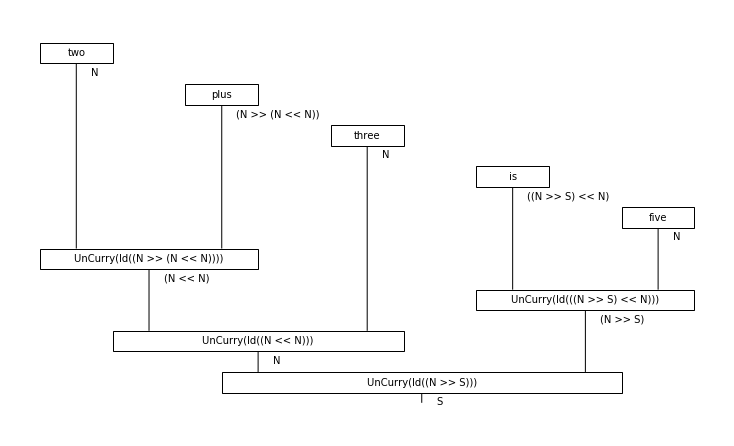

In [8]:
sentence.draw(figsize=(10, 6))